In [1]:
#do this later from admin: !python -m pip install --upgrade pip


# TOC

Find centroids on train, predict test centroids

0. [Imports](#first-bullet)
1. [EDA](#1.0-bullet)
2. [Feature Engineering](#2.0-bullet)  
 2.1 [Pt 1 - Regression](#2.1-bullet)  
 2.2 [Pt 2 - Classification](#2.2-bullet)
3. [Basic Model](#3.0-bullet)  
 3.1 [Pt 1 - Regression](#3.1-bullet)  
 3.2 [Pt 2 - Classification](#3.2-bullet)
4. [Reference and Planning](#4.0-bullet)

# Do not Run All cells - lots of charts

In [1]:
#Basic
import pandas as pd
import numpy as np
#Math
import scipy as sp
from random import randint
from math import exp
import operator

#Scraping
import requests
import json

#Youtube Data API Packages: 
from apiclient.discovery import build
from apiclient.errors import HttpError
from oauth2client.tools import argparser
from googleapiclient.discovery import build
import argparse
"""
from googleapiclient.errors import HttpError"""

#Modeling
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
#from sklearn.linear_model import LogisticRegression
#from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.cluster import KMeans
#from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

#NLP & Text Management
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from textblob import TextBlob
from wordcloud import WordCloud
from nltk.stem import PorterStemmer

#Time analysis
import time
import datetime as dt
"""from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf"""

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
#from wordcloud import WordCloud

%matplotlib inline
plt.style.use('seaborn-whitegrid')
sns.set_style('whitegrid')

In [2]:
df_main = pd.read_csv('./data/clean_data_nocomments_noviews_02.10.18.csv')

#create log features

In [3]:
df_main['view_log'] = df_main['viewCount'].map(lambda x: 0 if x==0 else np.log10(x)) #Which log to use???
df_main.publishedAt = pd.to_datetime(df_main.publishedAt)
df_main['week'] = df_main.publishedAt.map(lambda x: x.week)

df_main.description.fillna('', inplace=True)

df_main.tags.fillna('', inplace=True)

In [4]:
Run_Text_Analysis = False

# <a class="anchor" id="1.0-bullet"> 1. EDA</a>

In [149]:
df_main.columns

Index(['caption', 'channelTitle', 'commentCount', 'defaultLanguage',
       'definition', 'description', 'dislikeCount', 'duration',
       'favoriteCount', 'licensedContent',
       ...
       'descr_word_yeah', 'descr_word_year', 'descr_word_yo', 'descr_word_you',
       'descr_word_young', 'descr_word_your', 'descr_word_youtu',
       'descr_word_youtub', 'descr_word_yt', 'descr_word_şarkısı'],
      dtype='object', length=542)

In [150]:
df_main.shape

(8694, 542)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


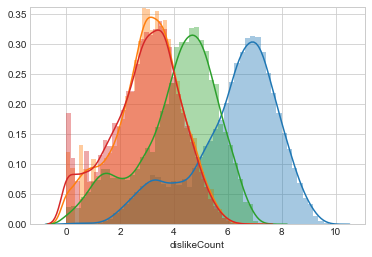

In [15]:
sns.distplot(np.log10(df_main[df_main.viewCount>0].viewCount)) #Views
sns.distplot(np.log10(df_main[df_main.commentCount>0].commentCount)) #Comments
sns.distplot(np.log10(df_main[df_main.likeCount>0].likeCount)) #Likes
sns.distplot(np.log10(df_main[df_main.dislikeCount>0].dislikeCount)) #dislikes -- very similar to comments 

# <a class="anchor" id="2.0-bullet"> 2. Feature Engineering</a>

* Description
 * Sentiment
 * CVEC x
 * Overall word count
* Tags
 * Sentiment
 * CVEC
 * Num tags
* Title
 * Sentiment
 * CVEC predictions
 * feat / ft. 
 * Which letters
 * Length
* Measures
 * Log features
  * commentCount, 
  * dislikeCount, 
  * favoriteCount, 
  * likeCount
  * viewCount: view_log


## <a class="anchor" id="2.1-bullet">2.1 Adding Features</a>



### Description
 * Sentiment description_sentiment
 * Overall word count description_wordcount
 * CVEC matrix

In [5]:
df_main['description_sentiment'] = df_main['description'].map(lambda x: TextBlob(str(x)).sentiment.polarity) #Title)

In [6]:
df_main['description_wordcount'] = df_main['description'].map(lambda x: str(x).count(' '))

In [9]:
if Run_Text_Analysis: 
    df_corp3= pd.DataFrame([corpus_string3], index=[1])
    cvec = CountVectorizer()
    df_cvec_description = cvec.fit_transform(df_corp3[0]).todense()

    df_cvec_description = pd.DataFrame(df_cvec_description, columns = cvec.get_feature_names())

    descr_words = [col for col in df_cvec_description.columns if df_cvec_description[col].sum()>200]

    lmtzr = PorterStemmer()
    lem_list = []
    for word in descr_words:
        lem_list.append(lmtzr.stem(word))
    lem_list = list(set(lem_list))

    for word in lem_list:
        df_main[str('descr_word_' + word)] = df_main.description.str.count(word)

### Tags
 * Sentiment
 * CVEC
 * Num tags

In [7]:
df_main['tags_sentiment'] = df_main['tags'].map(lambda x: TextBlob(str(x)).sentiment.polarity)

df_main['tags_wordcount'] = df_main['tags'].map(lambda x: str(x).count(','))

In [8]:
if Run_Text_Analysis: 
    df_corp2= pd.DataFrame([corpus_string2], index=[1])
    cvec = CountVectorizer()
    df_cvec_description = cvec.fit_transform(df_corp2[0]).todense()

    df_cvec_description = pd.DataFrame(df_cvec_description, columns = cvec.get_feature_names())

    descr_words = [col for col in df_cvec_description.columns if df_cvec_description[col].sum()>200]

    lmtzr = PorterStemmer()
    lem_list = []
    for word in descr_words:
        lem_list.append(lmtzr.stem(word))
    lem_list = list(set(lem_list))

    for word in lem_list:
        df_main[str('tag_word_' + word)] = df_main.description.str.count(word)

### Title
 * Sentiment
 * Wordcount
 * CVEC predictions
 * feat / ft. 
 * Which letters
 * Length

In [9]:
df_main['title_sentiment'] = df_main['title'].map(lambda x: TextBlob(str(x)).sentiment.polarity)
df_main['title_wordcount'] = df_main['title'].map(lambda x: str(x).count(' '))

In [10]:
feat_words = ['feat', 'ft', 'featur']
def find_feats(text_string):
    text_string = text_string.lower()
    for word in feat_words:
        if word in text_string:
            return 1
    return 0
df_main['title_featuring'] = df_main['title'].map(lambda x: find_feats(x))

In [11]:
df_main[df_main['title_featuring']==1]['viewCount'].mean() / df_main[df_main['title_featuring']==0]['viewCount'].mean()

2.7215569134095174

In [12]:
letters = 'abcdefghijklmnopqrstuvwxyz'
for letter in letters:
    df_main[str('intitle_' + letter)] = df_main.title.str.count(letter)

In [13]:
df_main.intitle_e.corr(df_main.viewCount)

-0.0008536683101137517

In [14]:
dict_letters = {}
for letter in letters:
     dict_letters[letter] = df_main['intitle_'+letter].corr(df_main.viewCount)

sorted_by_value = sorted(dict_letters.items(), key=lambda kv: kv[1])

sorted_by_value

[('p', -0.03946633529244498),
 ('b', -0.03627860822539604),
 ('s', -0.03514826615159203),
 ('r', -0.027404929357270034),
 ('m', -0.027279484193756025),
 ('v', -0.026577086391472934),
 ('g', -0.02449266351460775),
 ('z', -0.02239357878936587),
 ('x', -0.021399371434054345),
 ('j', -0.02137359415623475),
 ('o', -0.02070718509871761),
 ('w', -0.014108489879490082),
 ('n', -0.01217125240695847),
 ('q', -0.007299119232882848),
 ('c', -0.006712985589303544),
 ('t', -0.002084847977073171),
 ('u', -0.0010196579409205704),
 ('e', -0.0008536683101137517),
 ('y', 0.0009580579318070765),
 ('l', 0.004137700055334141),
 ('h', 0.006063303890828201),
 ('d', 0.020119382926463092),
 ('a', 0.027141420170195565),
 ('k', 0.030337263703497507),
 ('i', 0.04360353842855648),
 ('f', 0.13541303454369089)]

Look at f go!

In [15]:
df_main['title_length'] = df_main['title'].map(lambda x: len(str(x)))

In [16]:
df_main.title_length.corr(df_main.view_log)

0.02566059747225844

In [17]:
if Run_Text_Analysis: 
    df_corp1= pd.DataFrame([corpus_string1], index=[1])
    cvec = CountVectorizer()
    df_cvec_description = cvec.fit_transform(df_corp1[0]).todense()

    df_cvec_description = pd.DataFrame(df_cvec_description, columns = cvec.get_feature_names())

    descr_words = [col for col in df_cvec_description.columns if df_cvec_description[col].sum()>200]

    lmtzr = PorterStemmer()
    lem_list = []
    for word in descr_words:
        lem_list.append(lmtzr.stem(word))
    lem_list = list(set(lem_list))

    for word in lem_list:
        df_main[str('title_word_' + word)] = df_main.description.str.count(word)

    len(lem_list)

### Other

In [18]:
df_main[(df_main['likeCount']>0)&(df_main['viewCount']<=5)]['likeCount']

5632      1
5845    527
6235      1
6236      1
8498     82
Name: likeCount, dtype: int64

In [19]:
df_main.at[5632, 'likeCount'] = 0
df_main.at[5845, 'likeCount'] = 0
df_main.at[6235, 'likeCount'] = 0
df_main.at[6236, 'likeCount'] = 0
df_main.at[6279, 'likeCount'] = 0
df_main.at[8498, 'likeCount'] = 0

In [20]:
df_main['lv_ratio'] = (df_main['likeCount'] / df_main['viewCount'])

In [21]:
df_main['lv_ratio'].fillna(1, inplace=True)

df_main.loc[: , ['lv_ratio', 'viewCount', 'view_log']].corr()

,lv_ratio,viewCount,view_log
lv_ratio,1.000000,-0.063052,-0.316753
viewCount,-0.063052,1.000000,0.376019
view_log,-0.316753,0.376019,1.000000


## <a class="anchor" id="2.2-bullet">2.2 Classification</a>



In [23]:
df_main['view_class'] = df_main.view_log.astype(int)

# <a class="anchor" id="3.0-bullet"> 3. Basic Model</a>

In [87]:
cols_exclude = ['letter_search', 'request_token', 'channelTitle', 'defaultLanguage', 'description', 'tags', 
               'title', 'vidId', 
               'month', 'publishedAt', 
               'viewCount','view_log','view_class', 'commentCount', 'favoriteCount', 'dislikeCount', 'likeCount']
cols_include_initial = [col for col in df_main.columns if col not in cols_exclude]
cols_include_final = [col for col in df_main.columns if col not in cols_exclude ]#and col not in others_to_exclude
X = df_main.loc[:, cols_include_final]
y = df_main.view_class

## <a class="anchor" id="3.1-bullet">3.1 Unsupervised Learning</a>



In [120]:
from sklearn.cluster import DBSCAN, KMeans

In [138]:
from sklearn.metrics import silhouette_score

In [146]:
for n in range(10, 61, 5):
    classifier = KMeans(n_clusters=n)
    classifier.fit_predict(X=df_classified)
    print('   n: ', n, ' score: ', classifier.inertia_)


   n:  10  score:  323735.0154664527
   n:  15  score:  304300.95188746974
   n:  20  score:  289835.56074752053
   n:  25  score:  281633.9412256931
   n:  30  score:  274818.29518382373
   n:  35  score:  268994.23680192244
   n:  40  score:  264631.0371473209
   n:  45  score:  260375.46011602212
   n:  50  score:  256977.50355105224
   n:  55  score:  253389.46560993863
   n:  60  score:  250997.27975188356


In [171]:
for i in range(30, 50):
    df_classified = pd.DataFrame(StandardScaler().fit_transform(X)).join(y)
    classifier = KMeans(n_clusters=20, random_state=i)
    df_classified = df_main.join(pd.DataFrame(pd.Series(classifier.fit_predict(X=df_clssified)), columns=['kclass']))
    print('    i: ', i, ' max: ', df_classified.loc[:, ['kclass', 'view_log']].groupby('kclass').mean().max())

    i:  30  max:  view_log    7.337068
dtype: float64
    i:  31  max:  view_log    7.351191
dtype: float64
    i:  32  max:  view_log    7.349823
dtype: float64
    i:  33  max:  view_log    7.39974
dtype: float64
    i:  34  max:  view_log    7.347003
dtype: float64
    i:  35  max:  view_log    7.372282
dtype: float64
    i:  36  max:  view_log    7.508084
dtype: float64
    i:  37  max:  view_log    7.35118
dtype: float64
    i:  38  max:  view_log    7.326899
dtype: float64
    i:  39  max:  view_log    7.350033
dtype: float64
    i:  40  max:  view_log    7.350779
dtype: float64
    i:  41  max:  view_log    7.510703
dtype: float64
    i:  42  max:  view_log    7.33851
dtype: float64
    i:  43  max:  view_log    7.341986
dtype: float64
    i:  44  max:  view_log    7.327781
dtype: float64
    i:  45  max:  view_log    7.514125
dtype: float64
    i:  46  max:  view_log    7.357322
dtype: float64
    i:  47  max:  view_log    7.342221
dtype: float64
    i:  48  max:  view_log    7

In [169]:
df_classified[df_classified.title.str.contains('Despacito')].loc[:, ['title', 'viewCount', 'kclass']]

,title,viewCount,kclass
3270,Luis Fonsi - Despacito ( cover by J.Fla ),127411039,1
7479,Luis Fonsi - Despacito ft. Daddy Yankee,5555912002,1
7594,"Luis Fonsi, Daddy Yankee - Despacito (Remix Au...",633857377,13


It looks like the cutoff should be somewhere around 7.4 for view log

In [174]:
df_main[df_main.view_log>7.5].shape

(1799, 63)

In [177]:
df_main.iloc[0:1, :].loc[:, ['view_log', 'viewCount']]

,view_log,viewCount
0,6.571227,3725863


In [178]:
10**6.571227

3725864.013677085

## <a class="anchor" id="3.2-bullet">3.2 Classification</a>



### 3.2.1 Classification - Basic Basic

In [148]:
X_train, X_test, y_train, y_test=train_test_split(X, y)

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

model = GradientBoostingClassifier()
model.fit(X_train_sc, y_train)

preds = model.predict(X_test_sc)

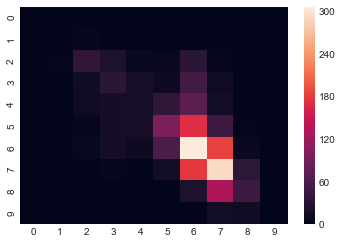

In [150]:
cm = confusion_matrix(y_test, preds)
sns.heatmap(pd.DataFrame(cm))

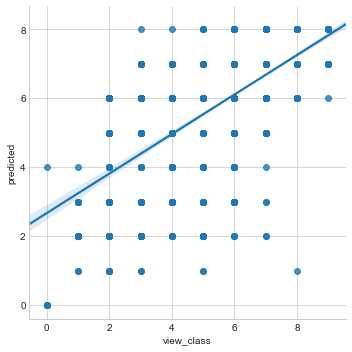

In [30]:
df_residuals = pd.DataFrame(y_test)
df_residuals['predicted'] = preds
df_residuals['residuals'] = df_residuals.predicted - df_residuals.view_class
sns.lmplot('view_class', 'predicted', data=df_residuals)

In [31]:
r2_score(df_residuals.view_class, df_residuals.predicted)

0.40591238461227497

In [29]:
df_big = df_main[df_main.viewCount > 100000000]
df_big_ss = ss.transform(df_big.loc[:, cols_include_initial])

df_big['predicted'] = 10**model.predict(df_big_ss)

#df_big.viewCount = df_big.viewCount.map(lambda x: '{:.6g}'.format(x))

df_big.loc[:, ['title', 'viewCount', 'predicted']].sort_values(by='viewCount', ascending=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,title,viewCount,predicted
7479,Luis Fonsi - Despacito ft. Daddy Yankee,5555912002,100000000
4268,Ed Sheeran - Shape of You [Official Video],3827104659,10000000
7190,Wiz Khalifa - See You Again ft. Charlie Puth [...,3788737518,10000000
5540,Mark Ronson - Uptown Funk ft. Bruno Mars,3256917992,100000000
3634,PSY - GANGNAM STYLE(강남스타일) M/V,3218413082,10000000
569,Justin Bieber - Sorry (PURPOSE : The Movement),3014897224,1000000000
7417,Maroon 5 - Sugar,2756205542,1000000000
7514,Taylor Swift - Shake It Off,2650920924,100000000
5506,Katy Perry - Roar (Official),2638406673,100000000
627,Enrique Iglesias - Bailando (Español) ft. Desc...,2582945265,1000000000


In [183]:
y=1*(df_main.view_log>7.5)

In [185]:
X_train, X_test, y_train, y_test=train_test_split(X, y)

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [186]:
model = GradientBoostingClassifier()
model.fit(X_train_sc, y_train)

preds = model.predict(X_test_sc)

In [187]:
model.score(X_test_sc, y_test)

0.8316467341306347

In [188]:
roc_auc_score(y_test, preds)

0.6690710482955106

## <a class="anchor" id="3.2-bullet">3.2 KCLass binary</a>



## <a class="anchor" id="3.3-bullet">3.3 Neural Net</a>



In [33]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [34]:
X = df_main.loc[:, cols_include_initial]

In [38]:
#for state in range(5, 56, 10):
X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=42)

In [39]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [50]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

model = Sequential()
#this does input and first activation
model.add(Dense(X_train_sc.shape[1], activation='relu', input_dim=X_train_sc.shape[1]))
model.add(Dropout(.5))
#model.add(Dense(20, activation='relu'))
#model.add(Dropout(.5))
#model.add(Dense(10, activation='relu'))

model.add(Dense(y_train_cat.shape[1], activation='softmax')) #1 neuron
model.compile(loss='categorical_crossentropy', optimizer='adam')

history = model.fit(X_train_sc, y_train_cat, validation_data=(X_test_sc, y_test_cat), epochs=40, verbose=0)
preds = model.predict(X_test_sc)
#print( 'score: ', r2_score(y_test, preds))

In [54]:
preds[0]

array([4.8751064e-10, 3.2303380e-08, 1.2714840e-03, 6.7004845e-02,
       2.9312417e-01, 3.0991632e-01, 2.6155320e-01, 6.7083307e-02,
       4.6626017e-05, 6.7871694e-11], dtype=float32)

In [58]:
preds_cat = []
for i in range(len(preds)):
    preds_cat.append(list(preds[i]).index(max(preds[i])))

In [65]:
len(preds_cat)

2174

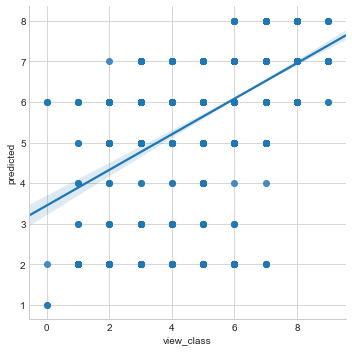

In [80]:
sns.lmplot('view_class', 'predicted', data=temp)

In [79]:
temp.columns

Index(['view_class', 'predicted'], dtype='object')

In [78]:
temp = pd.DataFrame([y_test]).T.reset_index().drop('index', axis=1)
temp['predicted'] = preds_cat

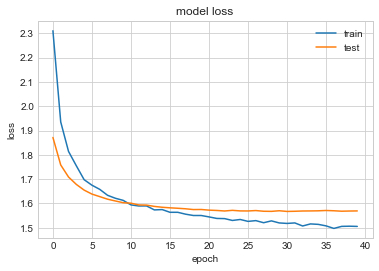

In [53]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show();

In [55]:
#Save point 1
#df_new.to_csv('./data/alphabet_pull_init_01.10.18.csv', index=False)

In [ ]:
#nope: AdaBoostRegressor, 

## <a class="anchor" id="3.2-bullet">3.2 Interpretation and Advanced Cleaning</a>


# <a class="anchor" id="4.0-bullet"> 4.0 Reference and Planning</a>

In [ ]:
# all views over 400M https://www.youtube.com/playlist?list=PLirAqAtl_h2r5g8xGajEwdXd3x1sZh8hC

Are there bots? would explain difference in like / view ratio.

### Next Steps
Feature engineering
* NLP - check only most 1000 common words according to corpus string (or above threshold) xx
* Comments / likes to views ratio? x
* Duration group classifications instead of just duration (eh)

Classification
* Do breakpoints by order of magnitude? That's sort of where this started. By analyzing differences, can establish if/then statements
* Find k classifications


## Columns Decisions
* Convert 
 * Duration x
 * PublishedAt X
* Get dummies: 
 * definition, (0 for sd, 1 for hd)
 * licensedContent (map)
 * Caption (map)
* Drop:
 * Projection, 
 * Dimension
 * 3d movies,
 * livebroadcast
 * CategoryID
 * channelID (already have title, which has text!!)
 * LiveBroadCastContent
* Leave in for EDA, but anticipate dropping during most analysis (basically stuff that might be interesting)
 * Region restriction should be dropped until modeling - consider bringing this back later
 * ContentRating - insignificant but interesting
 * Could look at channelTitle
 * request_token
 * letter_search
 * defaultLanguage, (might be better as 1 / 0 for set / not set. leave for model)